# Lab Assignment Three: Extending Logistic Regression
by:
* Hayden Donofrio
* Riley Bates
* Chandler Choate

## Section 1: Preparation and Overview

### Business Case

The dataset that we chose for this lab is called [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification), and is comprised of around 25,000 scenery images around the world broken into different categories: buildings, forests, glaciers, mountains, seas, and streets. One of the main reasons for neural networks is to help the process of grouping and classifying the data given. This process can save a lot of time because you are not having to separate each item, one by one, to the correct section. Our model, if successful, could be incredibly useful in the fields of reconnaissance and satellite imagery. Our model could be used to group and sort thousands of different images into different types of landscapes before the images are touched by human hands, saving analysts the time of sifting through all these images. For example, if an analyst is looking for possible locations based on existing imagery data, they could search through the already classified mountainous or desert region imagery.

However, one limitation is the fact that most of our image dataset is not taken from an aerial view, so the model may not perform well when given satellite imagery as input, but would still perform as expected when used with other images of the scenery. Our model could also possibly be used by photojournalism companies as an initial classifier, and with further work on the model, we may be able to recognize the same scene in various images, such as recognizing two different images of Reunion Tower in Dallas.

This model would need to perform quite highly in order to be able to make a difference compared to what is already out there. If this network is not performing up to par with similar algorithms then the function is useless. This multi-layer perception would need to perform in the top percentiles of time and accuracy for interested parties to even want to take a look at this algorithm. In today’s world, many companies, if not all, have deadlines and if the process takes too long to classify and is not correctly sorting, then why take the time to test it on your specific needs. Overall for this prediction algorithm to be useful, it will need to be accurate and time efficient with unique and close to perfect results/models to back up tasks at hand.

Dataset Source: https://www.kaggle.com/puneet6060/intel-image-classification

### Prepare Data

In [195]:
yourpath = 'intel-image-classification'
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import contextlib
import os
import cv2
images = {}
X = []
y = []
list_counter = -1
strs = []
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        try:
            regx = re.compile("[a-zA-Z]+$")
            image = cv2.imread(os.path.join(root, name),0)
            image = cv2.resize(image,(150,150))
            image = (image.flatten())
            key = regx.search(root).group(0)
            if key not in strs:
                strs.append(key)
                list_counter += 1
            image = (image/255.0 - .5)
            X.append(image)
            y.append(list_counter)
        except:
            continue

In [196]:
Xp = []
for i in X:
    Xp.append(i.reshape(1,22500))
X = np.array(Xp).reshape(len(Xp),22500)
print(X.shape)

(17034, 22500)


(17034, 22500)


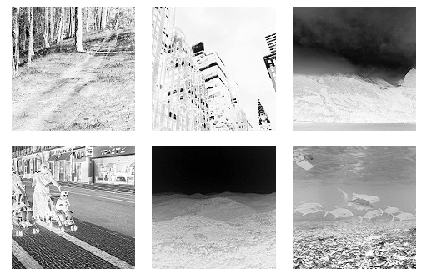

In [197]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,)
ax = ax.flatten()
y = np.array(y)
print(X.shape)
for i in range(6):
#     print(X[0])
    img = X[y == i][0].reshape(150,150)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Dataset Description

The dataset is now comprised of resized, greyscale images that are encoded based on location. We have around 17,000 images in our dataset now. Let's take a look at how this is broken up between classes.

In [198]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)
#print((X).reshape(17034, 22500))

[[   0 2745]
 [   1 2628]
 [   2 2957]
 [   3 2883]
 [   4 3037]
 [   5 2784]]


### Training and Testing Division Method

Since we have plenty of data for each class, we may not need to implement K-folds, and could instead implement a test/train split. We believe that this is representative of the way that the dataset would be used in a real world implementation, for a couple reasons. 

The main motivator in using K-fold subsets is to prevent overfitting due to data not being stratified, for example, most of the test set being of one or two classes. This is a huge danger in the train/test split method - you have to ensure that the split is random, and is representative of the entire dataset. In our dataset, we do not have a much smaller percentage of one or two classes, with all 6 being fairly uniform in size.

However, it could still be argued that K-fold validation is still a safer bet, right? This is true, and in a perfect world, we believe that 3 fold cross validation would be a good balance since the dataset is somewhat large, and this would balance the error due to variance and the error due to bias when deciding on the number of folds. But, we are working with a fairly large image dataset that may have to be retrained often in real practice, as more images are being added. The primary disadvantage of K-fold validation is that the training algorithm has to be rerun from scratch k times, which means it is very computationally expensive.

For this reason, we believe that using a stratified train/test 80% split is a fair balance of computation and time constraints while also avoiding overfitting too much to our training data.

In [199]:
# use an 80/20 stratified split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3406, 22500)
(3406,)
(13628, 22500)
(13628,)


### Evaluation Metric

For classifying this dataset, we didn't think that accuracy was the best measure of how well the model performed. We did some research on ways to evaluate neural networks (read [this](https://jenstirrup.com/2017/08/01/how-do-you-evaluate-the-performance-of-a-neural-network-focus-on-azureml/) and [this](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)) and decided that using F1 score would be a good evaluation metric, because we want a good balance between precision and recall.

We know that precision takes false positives into account and recall takes false negatives into account. Using just one of these indicators isn't perfect, because we do care about both false positive and negative cases in our business scenario. Our business use case is focused on identifying the type of location in an image to either ease the load of a human worker or to provide accurate results itself. In either case, we do not want to misclassify an image and totally throw it out if the model is uncertain.

We know that accuracy can be largely contributed by a large number of true negatives which in most business circumstances, we do not focus on much whereas false negative and false positive usually has business costs, so F1 score will probably be a better measure to use in order to seek a balance between precision and recall.

## MLP Implementation

In [ ]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, steps=2, phi="sigmoid", cost="quad"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.steps = steps
        self.phi = phi
        self.cost= cost
        self.num_gradients = n_hidden + 2
        self.gradients = np.zeros(self.num_gradients,)
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        Ws = []
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        Ws.append(W1)
        for i in range(1, self.steps):
            if i +1 == self.steps:
                W2_num_elems = (self.n_hidden + 1)*self.n_output_
                W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
                W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
                Ws.append(W2)
            else:
                W_num_elems = ((Ws[i-1].shape[0]+1)*(self.n_hidden))
                W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
                W = W.reshape(self.n_hidden, Ws[i-1].shape[0]+1)
                Ws.append(W)
        return Ws
    
    @staticmethod
    def _sigmoid(z):
        # we should also have a linear function too
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _linear(z):
        print("LINEAR")
        return z
    
    def _phi(self, z):
        if self.phi == "sigmoid":
            return expit(z)
        elif self.phi == "linear":
            return z
        else:
            print >> sys.stderr, "Not a valid phi function (linear or sigmoid)"
            sys.exit(1)
            
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, Ws):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        means = 0
        for w in Ws:
            means += np.mean(w[:, 1:] ** 2)
        #Maybe?? Check this
        return (lambda_/len(Ws)) * (means)**(1/len(Ws))
    
    def _cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        #A3 = yhat
        cost = 0
        if self.cost == "cross":
            cost = -np.mean(Y_enc * np.log(A3) + (1-Y_enc)*np.log(1-A3))
        elif self.cost == "quad":
            cost = np.mean((Y_enc-A3)**2)
        else:
              print >> sys.stderr, "Not a valid cost function (quad or cross)"
              sys.exit(1)
        
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    

In [ ]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, Ws):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        As = [None]*(self.steps+1)
        Zs = [None]*self.steps
        for i in range(len(As)):
            if i==0:
                As[0] = self._add_bias_unit(X, how='column')
                As[0] = As[0].T
            else:
                Zs[i-1] = Ws[i-1] @ As[i-1]
                if i!=len(As)-1:
                    As[i] = self._phi(Zs[i-1])
                    As[i] = self._add_bias_unit(As[i], how='row')
                else:
                    As[i] = self._phi(Zs[i-1])
        return As, Zs

    def predict(self, X):
        """Predict class labels"""
        As, Zs = self._feedforward(X, self.Ws)
        y_pred = np.argmax(As[-1], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.Ws = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            As, Zs = self._feedforward(X_data,self.Ws)
            
            cost = self._cost(As[-1],Y_enc,self.Ws)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(As=As, Zs=Zs, Y_enc=Y_enc,
                                              Ws=self.Ws)
            for j in range(len(grads)):
                k = self.eta * grads[j]
                self.Ws[j] -= self.eta * grads[j]
            

        return self

In [ ]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        Vs = []
        grads = []
        for i in reversed(range(1,self.steps+1)):
            if self.cost == "quad":
                if i == self.steps:
                    v_last = -2*(Y_enc-As[i])*As[i]*(1-As[i])
                    grad_last = v_last @ As[i-1].T
                    Vs.append(v_last)
                    grads.append(grad_last)
                elif self.steps > 2 and i <= self.steps - 2 and i > 0:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0][1:,:])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0][1:,:]
                    Vs.insert(0,V)
                else:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])
                        V *= Ws[i].T @ Vs[0]
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0]
                    Vs.insert(0,V)
            else:
                if i==self.steps:
                    V = As[i]-Y_enc
                    Vs.insert(0,V)
                elif self.steps > 2 and i <= self.steps - 2 and i > 0:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0][1:,:])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0][1:,:]
                    Vs.insert(0,V)
                else:
                    V = None
                    if self.phi == 'sigmoid':
                        V = As[i]*(1-As[i])*(Ws[i].T @ Vs[0])
                    elif self.phi == 'linear':
                        V = Ws[i].T @ Vs[0]
                    Vs.insert(0,V)

        for i in reversed(range(0,len(Vs)-1)):
            grad = Vs[i][1:,:] @ As[i].T
            grad[:,1:] += Ws[i][:, 1:] * self.l2_C
            grads.insert(0,grad)
        
        self.gradients = grads
        return grads
    
    def get_params(self, deep=True):
        return {"n_hidden": self.n_hidden, 
                "epochs": self.epochs,
                "eta": self.eta, 
                "steps": self.steps,
                "phi": self.phi}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def get_gradients(self):
        return self.gradients

# Testing on Digit Data

Let's try it and see how it does!

In [220]:
###TESTING DATA
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
print(ds.data)
X = ds.data/16.0-0.5
print(X)
y = ds.target
print(y)
print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[[-0.5    -0.5    -0.1875 ... -0.5    -0.5    -0.5   ]
 [-0.5    -0.5    -0.5    ...  0.125  -0.5    -0.5   ]
 [-0.5    -0.5    -0.5    ...  0.5     0.0625 -0.5   ]
 ...
 [-0.5    -0.5    -0.4375 ... -0.125  -0.5    -0.5   ]
 [-0.5    -0.5    -0.375  ...  0.25   -0.5    -0.5   ]
 [-0.5    -0.5     0.125  ...  0.25   -0.4375 -0.5   ]]
[0 1 2 ... 8 9 8]
(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]
(1437, 64)
(1437,)
(360, 64)
(360,)


In [221]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              steps=4,
              phi="sigmoid",
              cost="quad")

In [222]:
%%time
from sklearn.metrics import f1_score
nn = TwoLayerPerceptronVectorized(**params)
nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('F1 Score:',f1_score(y_test,yhat,average='macro'))

Epoch: 200/200

F1 Score: 0.8785180601857187
CPU times: user 3.84 s, sys: 559 ms, total: 4.4 s
Wall time: 1.11 s


Obviously, these results are horrible, an F1 Score that low is not even close to where we want to be. However, let's see if this is due to our implementation or if this is a problem of the dataset and its difficulty.

Now let's compare our MLP implementation with SKLearn's.

## SKLearn MLP

In [223]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier

# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=False, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=True, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('SKLearn F1 Score:',f1_score(yhat,y_test,average='macro'))

CPU times: user 649 ms, sys: 121 ms, total: 771 ms
Wall time: 196 ms
SKLearn F1 Score: 0.9383819243785853


Although SKLearn did perform better than our model, these results are still nothing to be proud of. It is clear that the dataset is very difficult to model, and there are inherent problems with that  since even SKLearn's implementation is struggling to classify the data.

## Hyper Parameter Tuning

We can probably achieve higher performance if we fine tune the parameters a bit. We'll use a grid search to find the best parameters between the phi function for the initial layer (either sigmoid or linear), the cost function (either mean squared error or cross entropy), and the number of hidden layers used in the MLP.

### Compare: 
phi = sigmoid or linear <br>
cost = quad or cross <br>
number of layers: 2,3,5

In [ ]:
### Can't get this working for some reason ###
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {'phi': ['sigmoid', 'linear'], 
              'cost': ['quad', 'cross'],
              'n_hidden':[2,3,5]}

mlp = TwoLayerPerceptronVectorized()
gs = GridSearchCV(estimator=mlp,
                 param_grid=param_grid,
                 scoring='f1',
                 cv=2)
gs.fit(X_train, y_train)
print('Best parameters found:\n', gs.best_params_)


# scores = cross_val_score(gs, X_train, y_train, scoring = 'f1', cv=6)
# print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [231]:
# brute force hyper parameter search

param_grid = {'phi': ['sigmoid', 'linear'], 
              'cost': ['quad', 'cross'],
              'n_hidden':[20,30,50]}

# only search half of the grid space
# we are statistically likely to have found a very good set of parameters

for n in range(len(param_grid['n_hidden'])):
    for c in range(len(param_grid['cost'])):
        for p in range(len(param_grid['phi'])):
            nn = TwoLayerPerceptronVectorized(n_hidden=param_grid['n_hidden'][n], 
                  C=0.1,  
                  epochs=300, 
                  eta=0.001,  
                  phi=param_grid['phi'][p],
                  cost=param_grid['cost'][c],
#                       random_state=1,
#                       steps=4,
                  )
            nn.fit(X_train, y_train)
            yhat = nn.predict(X_test)
            print('\n\nHidden layers:',param_grid['n_hidden'][n])
            print('\nPhi:',param_grid['phi'][p])
            print('\nCost function:',param_grid['cost'][c])
            print('\nF1 Score:',f1_score(y_test,yhat,average='weighted'))



Hidden layers: 20

Phi: sigmoid

Cost function: quad

F1 Score: 0.9301203206349598


Hidden layers: 20

Phi: linear

Cost function: quad

F1 Score: 0.02328899972291493


Hidden layers: 20

Phi: sigmoid

Cost function: cross

F1 Score: 0.23852938971801257


Hidden layers: 20

Phi: linear

Cost function: cross

F1 Score: 0.02328899972291493


Hidden layers: 30

Phi: sigmoid

Cost function: quad

F1 Score: 0.9583925515931895


Hidden layers: 30

Phi: linear

Cost function: quad

F1 Score: 0.02328899972291493


Hidden layers: 30

Phi: sigmoid

Cost function: cross

F1 Score: 0.7213462165228897


Hidden layers: 30

Phi: linear

Cost function: cross

F1 Score: 0.02328899972291493


Hidden layers: 50

Phi: sigmoid

Cost function: quad

F1 Score: 0.9612213433108204


Hidden layers: 50

Phi: linear

Cost function: quad

F1 Score: 0.02328899972291493


Hidden layers: 50

Phi: sigmoid

Cost function: cross

F1 Score: 0.8977891338534139


Hidden layers: 50

Phi: linear

Cost function: cross

F1 

While the best results vary ever so slightly between runs, usually it is the case that the best hyper parameters are as follows: 50 hidden layers, sigmoid phi, and quadratic cost function. From now on, we will use these parameters unless making a comparison.

## Visualization

### Cross entropy vs Quadratic Cost Function

In [232]:
params_cross = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              steps=4,
              phi="sigmoid",
              cost="cross")

params_quad = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              steps=4,
              phi="sigmoid",
              cost="quad")

nn_quad = TwoLayerPerceptronVectorized(**params_quad)

nn_cross = TwoLayerPerceptronVectorized(**params_cross)

%time nn_cross.fit(X_train, y_train, print_progress=1)
%time nn_quad.fit(X_train, y_train, print_progress=1)
print("Done")

Epoch: 30/2000

CPU times: user 4.94 s, sys: 952 ms, total: 5.89 s
Wall time: 1.5 s


Epoch: 200/200

CPU times: user 4.58 s, sys: 843 ms, total: 5.42 s
Wall time: 1.37 s
Done


In [233]:
def calc_epochs(params, X_train, y_train, X_test, y_test):
    epochs = []
    for epoch in list(range(1, 200, 25)):
        nn = TwoLayerPerceptronVectorized(**params)
        nn.fit(X_train, y_train)
        yhat = nn.predict(X_test)
        score1 = f1_score(y_test, yhat, average='weighted')
        epochs.append([score1, epoch])
#         print(score1, epoch)
    return epochs

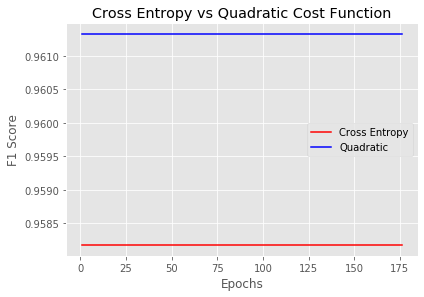

In [234]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="cross")
epochs_cross = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_cross = np.array(epochs_cross)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="quad")
epochs_quad = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_quad = np.array(epochs_quad)

plt.style.use('ggplot')

plt.plot(epochs_cross[:,1], epochs_cross[:,0], color='red',label='Cross Entropy')
plt.plot(epochs_quad[:,1], epochs_quad[:,0], color='blue',label='Quadratic')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.title("Cross Entropy vs Quadratic Cost Function")
plt.show()

While this graph does not fluctuate much, it clearly communicates that a quadratic cost function is overall more reliable to use than cross entropy.

### Linear vs Sigmoid Phi Function

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


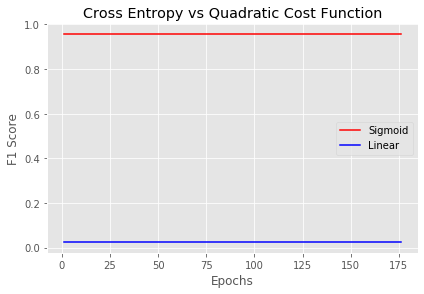

In [235]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="cross")
epochs_sigmoid = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_sigmoid = np.array(epochs_sigmoid)

params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="linear",
                  cost="cross")
epochs_linear = calc_epochs(params, X_train, y_train, X_test, y_test)
epochs_linear = np.array(epochs_linear)

plt.style.use('ggplot')

plt.plot(epochs_sigmoid[:,1], epochs_sigmoid[:,0], color='red',label='Sigmoid')
plt.plot(epochs_linear[:,1], epochs_linear[:,0], color='blue',label='Linear')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.title("Cross Entropy vs Quadratic Cost Function")
plt.show()

As shown above, using a linear phi function results in very, very low performance that does not improve in later epochs. Using a sigmoid phi function is recommended over this, although in real practice, we would likely implement another method such as ReLU or SiLU.

In [236]:
epochs = []
for epoch in list(range(20, 700, 25)):
    params = dict(n_hidden=50, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                 steps=4,
                 phi="sigmoid",
                 cost="quad")
    nn = TwoLayerPerceptronVectorized(**params)
    nn.fit(X_train, y_train)
    yhat = nn.predict(X_test)
    score1 = f1_score(y_test, yhat, average='macro')
    epochs.append([score1, epoch])
    print(score1, epoch)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.11185039251207729 20
0.2624400635658311 45
0.33865859324756414 70
0.4249225628799277 95
0.5759770011804268 120
0.8025949355432639 145
0.841301906073741 170
0.9169182109260863 195
0.8960853624201564 220
0.9334065780739091 245
0.9393676612932411 270
0.9483106402468529 295
0.9483106402468529 320
0.9515210219503853 345
0.9546538716877127 370
0.957341079242133 395
0.9546460219503853 420
0.9574597213667009 445
0.9574597213667009 470
0.9574597213667009 495
0.9574597213667009 520
0.9574597213667009 545
0.9574597213667009 570
0.9574597213667009 595
0.9574597213667009 620
0.9574597213667009 645
0.9603981214369501 670
0.9603981214369501 695


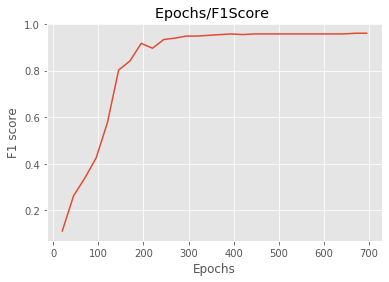

In [237]:
epochs = np.array(epochs)

fig = plt.figure()
plt.scatter(epochs[:,1],epochs[:,0], marker="")
plt.plot(epochs[:,1], epochs[:,0])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("Epochs/F1Score ")
plt.show()

### Custom MLP Implementation vs SKLearn Implementation

In [242]:
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=75, 
                    shuffle=False, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=True, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('SKLearn Validation Accuracy:',accuracy_score(yhat,y_test),'\n\n')


nn = TwoLayerPerceptronVectorized(n_hidden=50, 
                      C=0.1, # tradeoff L2 regularizer
#                       epochs=200, # iterations
                      eta=0.001,  # learning rate
                      random_state=1,
                      steps=4,
                      phi="sigmoid",
                      cost="quad")
%time nn.fit(X_train, y_train)
yhat = nn.predict(X_test)
print('Custom MLP Validation Accuracy:',accuracy_score(yhat,y_test))

CPU times: user 665 ms, sys: 126 ms, total: 790 ms
Wall time: 201 ms
SKLearn Validation Accuracy: 0.9388888888888889 


CPU times: user 8.77 s, sys: 1.16 s, total: 9.92 s
Wall time: 2.49 s
Custom MLP Validation Accuracy: 0.9583333333333334


Not bad...

### Gradient Magnitudes

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


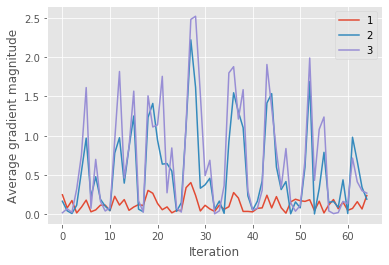

In [239]:
# visualize gradient magnitudes

params = dict(n_hidden=3, 
                  C=0.1,  # tradeoff L2 regularizer
                  epochs=epoch, # iterations
                  eta=0.001,  # learning rate
                  random_state=1,
                  steps=4,
                  phi="sigmoid",
                  cost="cross")
nn = TwoLayerPerceptronVectorized(**params)
nn.fit(X_train, y_train)
yhat = nn.predict(X_test)
score1 = f1_score(y_test, yhat, average='macro')

gradients = nn.get_gradients()

ax = plt.subplot(1,1,1)
for i in range(len(gradients)):
    plt.plot(abs(gradients[0][i]), label=i+1)
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

As expected, the later gradients have much larger changes in gradient magnitude because the first gradient calculations are multiplied by small fractions every time. This doesn't necessarily mean that the weights for those layers are training more quickly. Weights in the early layers of the network may hardly be updated with this type of model.

## Section 4: Exceptional Work

All three of our group members participated in the Biometrics research study.